* normalization: compute relative logs to itself
* categorization: group experiments by the matching training domain
* pairing: compute additional benefit of a new objective compared to the corresponding (paired) MLE objective
* --> for each Update step, compute additive "improvements" to corresponding MLE, then plot as a sum of "MLE + improvement"
* variance: for each Update step, plot each "improvement" as 1. either confidence interval (e.g. Violin), or 2. min + avg + max lineplot

In [415]:
experiments_ids = ["seq_wikimedia", "sbert_dist_wikimedia", "seq_opensub", "sbert_dist_opensub", "seq_bible", "sbert_dist_emea", "seq_emea", "sbert_dist_dgt", "seq_dgt",
                   "tbert_dec_wikimedia", "tbert_dec_opensub", "tbert_dec_bible", "tbert_dec_emea", "tbert_dec_dgt"]

In [428]:
import comet_ml
import pandas as pd

api = comet_ml.api.API(api_key="API_KEY")


def experiment_log(experiment_id: str, domain: str, metric: str = "BLEU",
                   project_name: str = "soft-obj2", smoothing_window: int = None) -> pd.Series:
    experiment = api.get("USERNAME", project_name, experiment_id)
    if experiment is None:
        print("No experiment %s" % experiment_id)
    metric_name = [k["name"] for k in experiment.get_metrics_summary() if metric in k["name"] and domain.lower()[:4] in k["name"].lower()]
    if not metric_name:
        print("No entry for experiment %s domain %s, metric: %s. Experiment keys: %s"
              % (experiment_id, domain, metric, [log["name"] for log in experiment.get_metrics_summary() if metric in log["name"]]))
        return None
    metrics = experiment.get_metrics(metric=metric_name[0])

    log = pd.Series([float(entry['metricValue']) for entry in metrics], index=[int(entry['step']) for entry in metrics])

    norm = log.iloc[0]
    log /= norm
    # smoothing?
    if smoothing_window is not None:
        log = log.rolling(window=smoothing_window, center=True).mean()
        log[pd.isna(log)] = 1
        log = log.iloc[smoothing_window - 2  // 2:-(smoothing_window // 2 + 1)]

    return log

In [406]:
experiment_log("tbert_dec_dgt", "emea")

500      1.000000
1000     1.049486
1500     1.070556
2000     1.079363
2500     1.097505
3000     1.158129
3500     1.158685
4000     1.170609
4500     1.203066
5000     1.181814
5500     1.213083
6000     1.244723
6500     1.184898
7000     1.221079
7500     1.248005
8000     1.221823
8500     1.189752
9000     1.358849
9500     1.352190
10000    1.357052
10500    1.342487
11000    1.335554
11500    1.350940
12000    1.349995
12500    1.350797
13000    1.352760
13500    1.353917
14000    1.351014
14500    1.347183
15000    1.350013
15500    1.347564
16000    1.353414
16500    1.352922
17000    1.351316
17500    1.355869
18000    1.358431
18500    1.356849
19000    1.358137
19500    1.361654
20000    1.372215
20500    1.369417
21000    1.368529
21500    1.360492
22000    1.363943
22500    1.360568
23000    1.358193
23500    1.357758
24000    1.348529
24500    1.352398
25000    1.354493
25500    1.356745
dtype: float64

In [409]:
# debug, will be removed
experiment_id = experiments_ids[0]
domain = "wikimedia"
metric: str = "BLEU"
project_name: str = "soft-obj2"
smoothing_window: int = None

experiment = api.get("stefanik12", project_name, experiment_id)
metrics = experiment.get_metrics(metric="eval_%s-Sequence2Sequence_%s-gen" % (domain, metric))
log = pd.Series([float(entry['metricValue']) for entry in metrics], index=[int(entry['step']) for entry in metrics])

norm = log.iloc[0]
log /= norm
# smoothing?
if smoothing_window is not None:
    log = log.rolling(window=smoothing_window, center=True).mean()
    log[pd.isna(log)] = 1
    log = log.iloc[smoothing_window - 2 // 2:-(smoothing_window // 2 + 1)]

log

AttributeError: 'NoneType' object has no attribute 'get_metrics'

In [410]:
objectives_identifiers = ["sbert_random", "sbert_dist", "sbert", "tbert", "seq"]

train_domains = ["wikimedia", "OpenSubtitles", "Bible", "EMEA", "DGT"]
eval_domains = ["wikimedia", "OpenSubtitles", "Bible", "EMEA", "DGT"]

In [430]:
experiment = api.get("stefanik12", "soft-obj2", "tbert_dec_bible")
experiment is None
# experiment_log("sbert_dist_opensub", "EMEA")

False

In [432]:
reference_logs = {}
reported_improvements = {}


for train_domain in train_domains:
    train_domain_experiments = [e for e in experiments_ids if train_domain.lower()[:4] in e.lower()]
    new_objective_experiments = [e for e in train_domain_experiments if "seq" not in e]

    reference_experiment_id = next(e for e in train_domain_experiments if "seq" in e)
    reference_logs[train_domain] = {eval_domain: experiment_log(reference_experiment_id, eval_domain) for eval_domain in eval_domains}
    reference_logs[train_domain] = {k: v for k, v in reference_logs[train_domain].items() if v is not None}

    reported_improvements[train_domain] = {}
    for eval_objective in new_objective_experiments:
        reported_logs = {eval_domain: experiment_log(eval_objective, eval_domain) for eval_domain in eval_domains}
        reported_improvements[train_domain][eval_objective] = {eval_domain: eval_log - reference_logs[train_domain][eval_domain]
                                                               for eval_domain, eval_log in reported_logs.items() if eval_domain in reference_logs[train_domain]}

No entry for experiment seq_wikimedia domain EMEA, metric: BLEU. Experiment keys: ['eval_Bible-Sequence2Sequence_BLEU-gen', 'eval_Opensub-Sequence2Sequence_BLEU-gen', 'eval_Wiki-Sequence2Sequence_BLEU-gen']
No entry for experiment seq_wikimedia domain DGT, metric: BLEU. Experiment keys: ['eval_Bible-Sequence2Sequence_BLEU-gen', 'eval_Opensub-Sequence2Sequence_BLEU-gen', 'eval_Wiki-Sequence2Sequence_BLEU-gen']
No entry for experiment seq_opensub domain EMEA, metric: BLEU. Experiment keys: ['eval_Bible-Sequence2Sequence_BLEU-gen', 'eval_Opensub-Sequence2Sequence_BLEU-gen', 'eval_Wiki-Sequence2Sequence_BLEU-gen']
No entry for experiment seq_opensub domain DGT, metric: BLEU. Experiment keys: ['eval_Bible-Sequence2Sequence_BLEU-gen', 'eval_Opensub-Sequence2Sequence_BLEU-gen', 'eval_Wiki-Sequence2Sequence_BLEU-gen']
No entry for experiment sbert_dist_opensub domain EMEA, metric: BLEU. Experiment keys: ['eval_OpenSubtitles-Sequence2Sequence_BLEU-gen', 'eval_val-Bible-Sequence2Sequence_BLEU-ge

In [119]:
reported_improvements

{'wikimedia': {'sbert_dist_wiki': {'wikimedia': 500      0.000000
   1000    -0.097411
   1500    -0.012830
   2000    -0.039531
   2500    -0.020282
              ...   
   32500         NaN
   33000         NaN
   33500         NaN
   34000         NaN
   34500         NaN
   Length: 69, dtype: float64,
   'OpenSubtitles': 500      0.000000
   1000     0.024150
   1500     0.044475
   2000     0.034010
   2500     0.052423
              ...   
   32500         NaN
   33000         NaN
   33500         NaN
   34000         NaN
   34500         NaN
   Length: 69, dtype: float64,
   'Bible': 500      0.000000
   1000     0.064132
   1500     0.033693
   2000     0.027074
   2500    -0.022245
              ...   
   32500         NaN
   33000         NaN
   33500         NaN
   34000         NaN
   34500         NaN
   Length: 69, dtype: float64}},
 'OpenSubtitles': {'sbert_dist_opensub': {'wikimedia': 30      NaN
   60      NaN
   90      NaN
   120     NaN
   150     NaN
            ..

<AxesSubplot:>

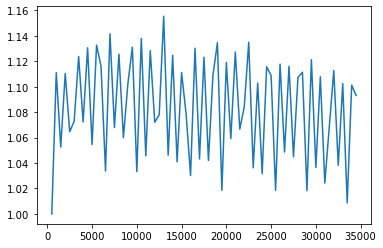

In [132]:
reference_logs["wikimedia"]["wikimedia"].plot()

<AxesSubplot:>

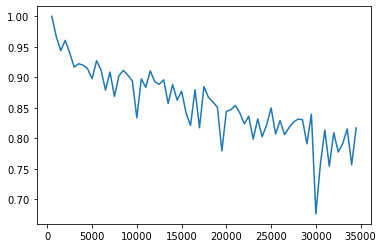

In [133]:
# non-smoothed version
reference_logs["wikimedia"]["OpenSubtitles"].plot()

<AxesSubplot:>

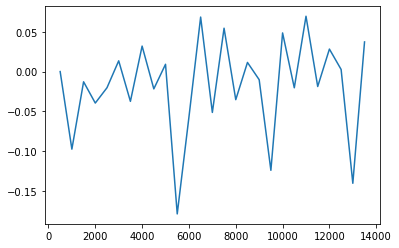

In [135]:
reported_improvements["wikimedia"]['sbert_dist_wiki']["wikimedia"].plot()

In [143]:
list(reference_logs.values())[0].keys(), train_domains

(dict_keys(['wikimedia', 'OpenSubtitles', 'Bible']),
 ['wikimedia', 'OpenSubtitles', 'Bible', 'EMEA', 'DGT'])

In [434]:
id_ref_all = pd.concat((pd.concat([eval_logs for eval_domain, eval_logs in train_domain_refs.items() if eval_domain == train_domain], axis=1)
                    for train_domain, train_domain_refs in reference_logs.items()), axis=1)

ood_ref_all = pd.concat((pd.concat([eval_logs for eval_domain, eval_logs in train_domain_refs.items() if eval_domain != train_domain], axis=1)
                          for train_domain, train_domain_refs in reference_logs.items()), axis=1)

In [435]:
id_ref = id_ref_all.loc[[i for i in id_ref_all.index if i % 500 == 0]].mean(axis=1)
ood_ref = ood_ref_all.loc[[i for i in ood_ref_all.index if i % 500 == 0]].mean(axis=1)

<AxesSubplot:>

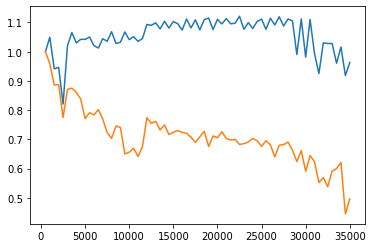

In [436]:
id_ref[id_ref.index <= 35000].plot()
ood_ref[ood_ref.index <= 35000].plot()

In [199]:
reference_logs

{'wikimedia': {'wikimedia': 500      1.000000
  1000     1.111085
  1500     1.052554
  2000     1.110496
  2500     1.064652
             ...   
  32500    1.038227
  33000    1.102478
  33500    1.008733
  34000    1.101190
  34500    1.093144
  Length: 69, dtype: float64,
  'OpenSubtitles': 500      1.000000
  1000     0.966545
  1500     0.943576
  2000     0.960415
  2500     0.939971
             ...   
  32500    0.777345
  33000    0.791241
  33500    0.815235
  34000    0.756317
  34500    0.816926
  Length: 69, dtype: float64,
  'Bible': 500      1.000000
  1000     0.921407
  1500     0.942234
  2000     0.939453
  2500     0.960057
             ...   
  32500    0.635594
  33000    0.605138
  33500    0.607292
  34000    0.606932
  34500    0.593180
  Length: 69, dtype: float64},
 'OpenSubtitles': {'wikimedia': 30      1.000000
  60      1.050874
  90      1.017944
  120     1.015102
  150     0.980412
            ...   
  7380    0.910178
  7410    0.918736
  7440    0.869

In [437]:
# remove the domain suffix from objectives identifiers
reported_improvements = {train_d: {"_".join(obj_id.split("_")[:2]): obj_logs for obj_id, obj_logs in obj_dict.items()} for train_d, obj_dict in reported_improvements.items()}

### Plotting

In [504]:
train_domains = ["wikimedia", "OpenSubtitles", "Bible", "EMEA", "DGT"]
eval_domains = ["wikimedia", "OpenSubtitles", "Bible", "EMEA", "DGT"]

In [505]:
plotted_objective = "tbert_dec"

In [506]:
objective_train_domains = [domain for domain, domain_logs in reported_improvements.items() if domain in train_domains and plotted_objective in domain_logs]

In [507]:
objective_train_domains

['wikimedia', 'OpenSubtitles', 'Bible', 'EMEA', 'DGT']

In [508]:
id_change = pd.concat([pd.DataFrame({eval_domain: logs
                                     for eval_domain, logs in reported_improvements[train_domain][plotted_objective].items()
                                     if train_domain == eval_domain})
                      for train_domain in objective_train_domains], axis=1)
id_change

,wikimedia,OpenSubtitles,Bible,EMEA,DGT
500,0.000000,NaN,0.000000,0.000000,0.000000
1000,-0.075409,NaN,-0.091240,-0.115438,0.005489
1500,0.016124,0.077145,-0.005160,0.001942,0.221055
2000,-0.033627,NaN,-0.040114,-0.136125,0.360171
2500,-0.009609,NaN,-0.126948,-0.115685,0.817808
...,...,...,...,...,...
83000,NaN,NaN,NaN,NaN,NaN
83500,NaN,NaN,NaN,NaN,NaN
84000,NaN,NaN,NaN,NaN,NaN
84500,NaN,NaN,NaN,NaN,NaN


In [509]:
id_improvement_upper = (id_ref + id_change.quantile(q=0.75, axis=1)).dropna()
id_improvement_mean =  (id_ref + id_change.mean(axis=1)).dropna()
id_improvement_lower = (id_ref + id_change.quantile(q=0.25, axis=1)).dropna()

In [510]:
ood_change = pd.concat([pd.DataFrame({eval_domain: logs
                                      for eval_domain, logs in reported_improvements[train_domain][plotted_objective].items()
                                      if train_domain != eval_domain})
                       for train_domain in objective_train_domains], axis=1)
ood_change

,OpenSubtitles,Bible,wikimedia,Bible,wikimedia,OpenSubtitles,EMEA,DGT,wikimedia,OpenSubtitles,Bible,DGT,wikimedia,OpenSubtitles,Bible,EMEA
500,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1000,0.043139,0.080112,NaN,NaN,0.092099,0.175105,0.038036,-0.016573,0.013321,0.025760,0.065207,0.007317,-0.007262,0.030478,0.045904,0.055997
1500,0.061676,0.059295,0.018224,0.12296,0.150330,0.171552,0.038506,0.105884,0.050723,0.052118,0.102690,-0.010741,0.269087,0.216092,0.072749,0.380551
2000,0.038922,0.058808,NaN,NaN,0.174965,0.139190,0.043948,0.023964,0.061831,0.048895,0.122043,-0.001683,0.114178,0.219659,0.066374,0.497013
2500,0.060480,0.036054,NaN,NaN,0.255496,0.175775,0.151678,0.048926,0.072532,0.078452,0.087783,0.018350,0.646380,0.430413,0.169528,1.001151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [511]:
ood_improvement_upper = (ood_ref + ood_change.quantile(q=0.75, axis=1)).dropna()
ood_improvement_mean =  (ood_ref + ood_change.mean(axis=1)).dropna()
ood_improvement_lower = (ood_ref + ood_change.quantile(q=0.25, axis=1)).dropna()

In [512]:
def subset_for_plot(series: pd.Series) -> pd.Series:
    # lower_q = series.quantile(0.125)
    # upper_q = series.quantile(0.975)
    # series = series[(lower_q <= series) & (series <= upper_q)]
    return series.loc[series.index <= 18000]

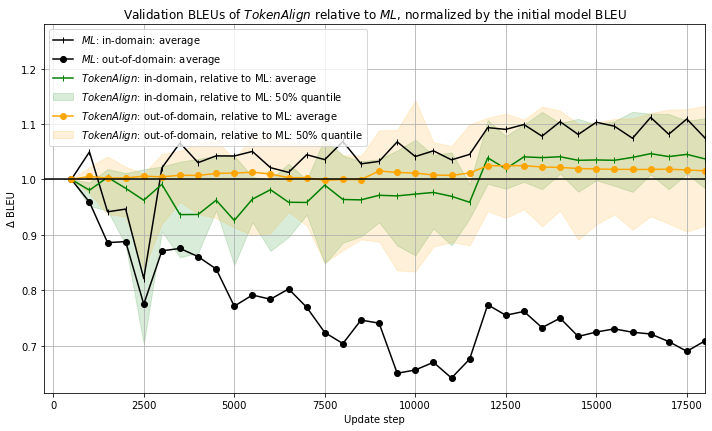

In [514]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# references plot
subset_for_plot(id_ref).plot(ax=ax, color="k", marker="|")
subset_for_plot(ood_ref).plot(ax=ax, color="k", marker="o")

# id mean change plot
subset_for_plot(id_improvement_mean.dropna()).plot(ax=ax, grid=True, figsize=(10, 6.1), color='g', marker="|")
# id: 50% interval plot
ax.fill_between(subset_for_plot(id_improvement_mean).index,
                subset_for_plot(id_improvement_lower).values,
                subset_for_plot(id_improvement_upper).values, color='g', alpha=.15)

# ood mean change plot
subset_for_plot(ood_improvement_mean).plot(ax=ax, grid=True, color='orange', marker="o")
# ood: 50% interval plot
ax.fill_between(subset_for_plot(ood_improvement_mean).index,
                subset_for_plot(ood_improvement_lower).values,
                subset_for_plot(ood_improvement_upper).values, color='orange', alpha=.15)

plt.xlabel("Update step")
plt.ylabel("Δ BLEU")
ax.set_ylim((0.615, 1.28))
ax.set_xlim((-250, 18000))

objective_label = "$TokenAlign$"

ax.legend(["$ML$: in-domain: average",
           "$ML$: out-of-domain: average",
           "{}: in-domain, relative to ML: average".format(objective_label),
           "{}: in-domain, relative to ML: $50\%$ quantile".format(objective_label),
           "{}: out-of-domain, relative to ML: average".format(objective_label),
           "{}: out-of-domain, relative to ML: $50\%$ quantile".format(objective_label)])
plt.axhline(y = 1.0, color = 'k', linestyle = '-')

_ = plt.title("Validation BLEUs of %s relative to $ML$, normalized by the initial model BLEU" % objective_label)
plt.tight_layout()
plt.savefig("%s-%s_train_domains-%s_eval_domains.pdf" % (plotted_objective, len(train_domains), len(eval_domains)), format="pdf", dpi=300)

ValueError: No objects to concatenate

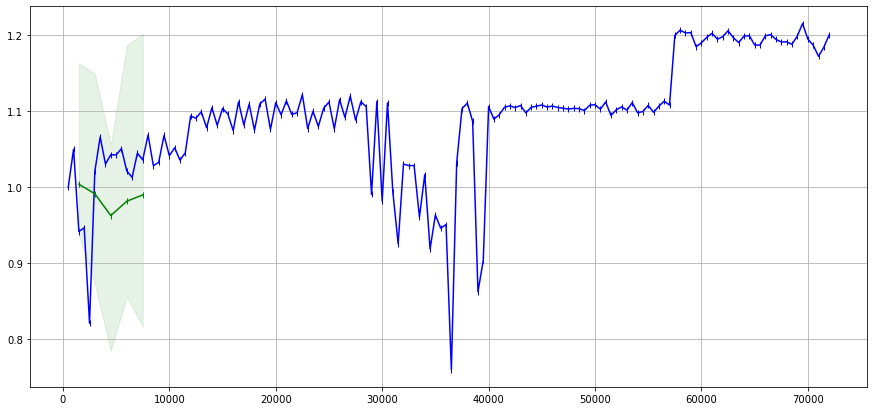

In [503]:
import matplotlib.pyplot as plt

# plotted_objective = "dec_sbert+seq_w25_lr1e-6_wiki"
# plotted_objective = "dec_tbert+seq_w25_lr2e-7_wiki"

objective_id = next(identifier for identifier in objectives_identifiers if identifier in plotted_objective)

# id
id_change = pd.concat((pd.concat([eval_logs for eval_domain, eval_logs in train_domain_refs[plotted_objective].items()
                                  if eval_domain == train_domain], axis=1)
                    for train_domain, train_domain_refs in reported_improvements.items()), axis=1)
id_change = id_change.dropna()

id_improvement_upper = (id_ref + id_change.max(axis=1)).dropna()
id_improvement_mean =  (id_ref + id_change.mean(axis=1)).dropna()
id_improvement_lower = (id_ref + id_change.min(axis=1)).dropna()

fig, ax = plt.subplots()
id_ref.plot(ax=ax, color="b", marker="|")
id_improvement_mean.dropna().plot(ax=ax, grid=True, figsize=(15, 7), color="g", marker="|")
ax.fill_between(id_improvement_mean.dropna().index, id_improvement_lower.dropna(), id_improvement_upper.dropna(), color='g', alpha=.1)

# ood
ood_change = pd.concat((pd.concat([eval_logs for eval_domain, eval_logs in train_domain_refs[plotted_objective].items()
                                  if eval_domain not in train_domains], axis=1)
                    for train_domain, train_domain_refs in reported_improvements.items()), axis=1)
ood_change = ood_change.dropna()

ood_improvement_upper = (ood_ref + ood_change.max(axis=1)).dropna()
ood_improvement_mean =  (ood_ref + ood_change.mean(axis=1)).dropna()
ood_improvement_lower = (ood_ref + ood_change.min(axis=1)).dropna()

# fig, ax = plt.subplots()
ood_ref.plot(ax=ax, color="b", marker="o")
ood_improvement_mean.plot(ax=ax, grid=True, figsize=(10, 5), color="g", marker="o")
ax.fill_between(ood_improvement_mean.index, ood_improvement_lower.values, ood_improvement_upper.values, color='g', alpha=.05)
plt.xlabel("Update step")
plt.ylabel("Δ BLEU")

ax.legend(["in-domain: MLE: mean",
           "in-domain: *TokenAlign*: min-max",
           "out-of-domain: *TokenAlign*: min-max ",
           "out-of-domain: MLE: mean",
           "out-of-domain: Token-distance: mean", ])
_ = plt.title("Validation BLEU of MLE and ''%s'' Objective - relative to the initial BLEU" % objective_id)
plt.tight_layout()
plt.savefig("%s-%s_train_domains-%s_eval_domains.pdf" % (plotted_objective, len(train_domains), len(eval_domains)), format="pdf", dpi=300)

In [11]:
id_change

,0
500,0.000000
1000,-0.113829
1500,-0.023578
2000,-0.077036
2500,-0.033613
...,...
32500,0.028307
33000,-0.008660
33500,0.081921
34000,0.016674
